In [1]:
import scanpy.api as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures


In [2]:
# %load C:/Users/Xiunan/Desktop/scanpy_flowgrid/test/_FlowGrid
import sys
sys.path.insert(0, 'C:/Users/Xiunan/Desktop/scanpy_flowgrid/test')
from _FlowGrid import FlowGrid
from _parameter_suggestion import parameter_suggestion
from _sc_FlowGrid import sc_FlowGrid

In [15]:
from time import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
adata = sc.read_csv('C:/Users/Xiunan/Desktop/Single cell/FlowGrid/data/sc_endoderm_all_cells_counts.csv', delimiter=',')

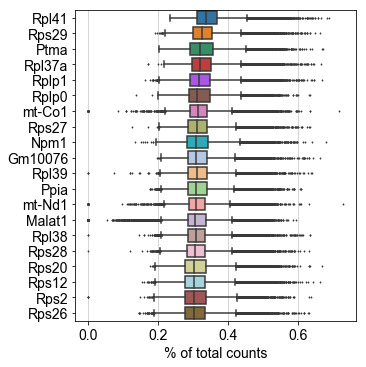

Trying to set attribute `.obs` of view, making a copy.


In [9]:
#############preprocessing##################
sc.pl.highest_expr_genes(adata, n_top=20)

#Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


In [6]:
#Normalization
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


In [8]:
adata.raw = adata
#selecting highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [11]:
#PCA to 5 dimensions#
sc.tl.pca(adata, n_comps=5)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 5
computing PCA on highly variable genes
    finished (0:00:04.41)


In [12]:
##Louvain clustering##
#getting neighbor graph
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=5)
#clustering
sc.tl.louvain(adata)

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished (0:00:46.53) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:01:50.74) --> found 27 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [13]:
adata

AnnData object with n_obs × n_vars = 113051 × 2485 
    obs: 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain'
    obsm: 'X_pca'
    varm: 'PCs'

In [16]:
#using Flowgrid to do clustering
#sc_FlowGrid(adata,bin_n,eps)
t1 = time()
sc_FlowGrid(adata,9,1.1)
print("running time: "+ str(round(time()-t1,3)))

running time: 0.234


In [37]:
#using parameter_suggestion to suggest parameters
#recomm_parameters = parameter_suggestion(adata,set_n,bin_n_range,eps_range)
#default bin_n_range = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
#        eps_range = [1.2, 1.6, 1.9, 2.1, 2.3, 2.7]
recomm_parameters = parameter_suggestion(adata, 5, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [1.2, 1.6, 1.9, 2.1, 2.3])


5 sets of parameters are recommended.
Suggestion completed in : 27.203 seconds.


In [38]:
recomm_parameters

['binN_11_eps_1.2_FlowGrid',
 'binN_10_eps_1.2_FlowGrid',
 'binN_14_eps_1.2_FlowGrid',
 'binN_12_eps_1.2_FlowGrid',
 'binN_13_eps_1.2_FlowGrid']

In [35]:
#umap
sc.tl.umap(adata)

computing UMAP
    using 'X_pca' with n_pcs = 5
    finished (0:01:53.61) --> added
    'X_umap', UMAP coordinates (adata.obsm)


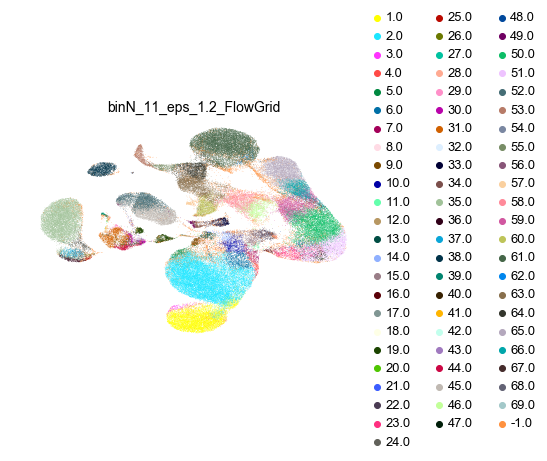

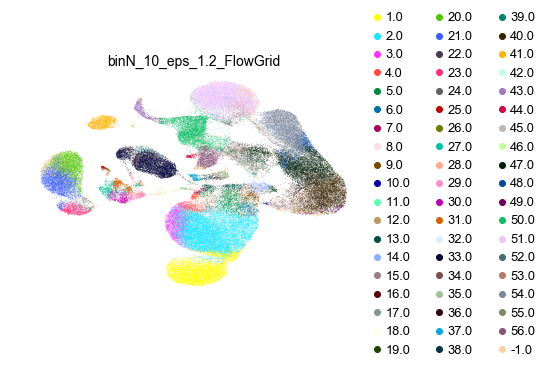

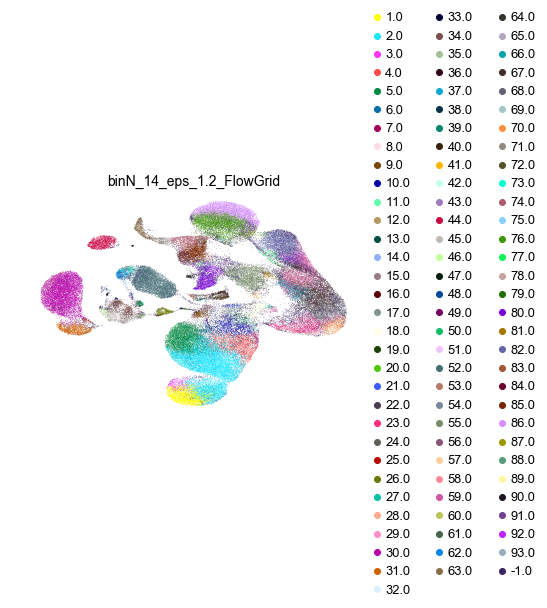

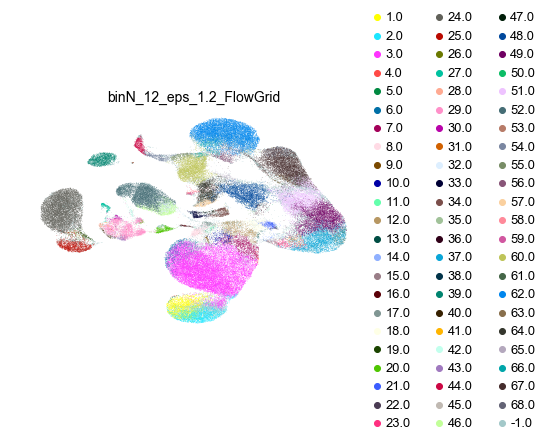

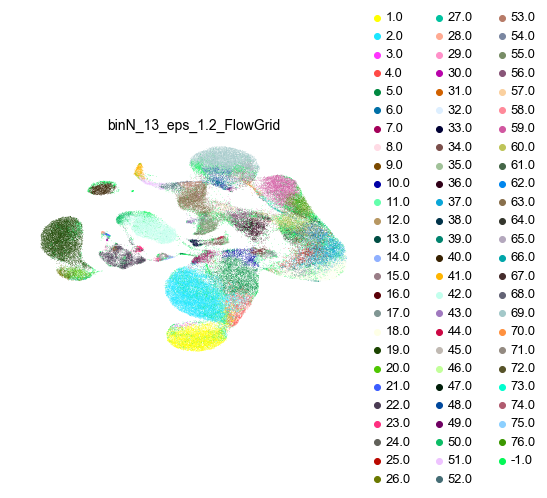

In [39]:
#plotting results of recommended parameters
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline

#sc.pl.umap(adata2, color=a,legend_loc= "on data" ,legend_fontsize = 8 ,legend_fontweight = 'light')
for i in range(len(recomm_parameters)):
    sc.pl.umap(adata, color=recomm_parameters[i],frameon =False)

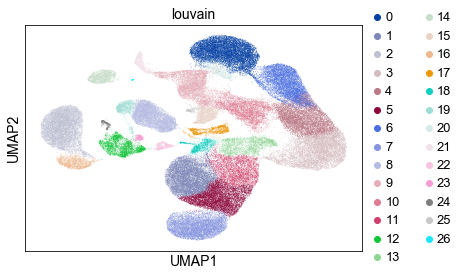

In [42]:
#plotting results of louvain for comparison
sc.pl.umap(adata, color=['louvain'])

... storing 'cellType' as categorical


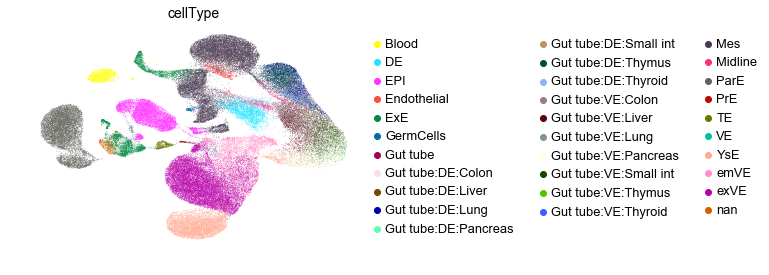

In [44]:
# Reference label
import pandas as pd
cellType_anno = pd.read_csv('C:/Users/Xiunan/Desktop/Single cell/FlowGrid/data/Labels.csv')
adata.obs['cellType'] = list(cellType_anno['CellType'])
sc.pl.umap(adata, color='cellType',color_map='jet',frameon =False)